In [1]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load training and testing sets from separate files
train_data = pd.read_csv("/Users/marlenawasiak/Desktop/Data_Collection/UNSW_NB15_training-set.csv")
test_data = pd.read_csv("/Users/marlenawasiak/Desktop/Data_Collection/UNSW_NB15_testing-set.csv")



In [3]:
X_train = train_data.drop(columns=['attack_cat'])
y_train = train_data['attack_cat']

X_test = test_data.drop(columns=['attack_cat'])
y_test = test_data['attack_cat']

# Encode categorical features
categorical_features = ['proto', 'service', 'state']
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Align test set columns with training set columns (fill missing columns with 0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode the target label (attack category) in both training and test sets
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [4]:
# Apply oversampling to the training set
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Scale the training and test sets
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test)                     # Only transform the test set

In [5]:
# Initialize and train the Random Forest model with class weight adjustments
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=10,
    class_weight='balanced',  # Helps handle any remaining class imbalance
    random_state=42
)

# Train the model on the resampled and scaled training set
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on the scaled test set
y_pred = rf_model.predict(X_test_scaled)

# Decode the target labels back to their original categories for interpretation
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test_decoded, y_pred_decoded))

print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

Confusion Matrix:
[[    0   584    20    40    18    14     1     0     0     0]
 [    0   490    20     6     9    14    22     2    17     3]
 [   19  2740    38   454    87    14   360    55   205   117]
 [  116  2930    62  4808   506    28   990    70   565  1057]
 [    0  1180    42    17  3365    28   416   138   761   115]
 [    5    36     0   290    91 18142   104     5   154    44]
 [ 1809     0     0    43  6639     0 27816   200   395    98]
 [    1   308     2     2    43     0   124  2468   158   390]
 [    0     0     0     0     5     0    25    16   332     0]
 [    0     0     0     0     2     0     0     0     8    34]]

Classification Report:
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.06      0.84      0.11       583
           DoS       0.21      0.01      0.02      4089
      Exploits       0.85      0.43      0.57     11132
       Fuzzers       0.31      0.56      0.40 

In [6]:

from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import BoundaryAttack

/opt/anaconda3/lib/python3.11/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [7]:
import numpy as np

classifier = SklearnClassifier(model=rf_model)

# Step 2: Select a subset of the test set for the Boundary Attack
# Here, we use the first 10 samples as an example
num_samples = 10
X_attack = X_test_scaled[:num_samples]
y_attack = y_test[:num_samples]

# Step 3: Initialize the Boundary Attack
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=1000, delta=0.01)

# Step 4: Generate adversarial samples

X_adv = attack.generate(x=X_attack)

# Step 5: Predict on the adversarial samples
y_pred_adv = classifier.predict(X_adv)

# Decode predictions and true labels to original categories for interpretation
y_pred_decoded_adv = label_encoder.inverse_transform(np.argmax(y_pred_adv, axis=1))
y_true_decoded_adv = label_encoder.inverse_transform(y_attack)

# Step 6: Display the results
print("Confusion Matrix after Boundary Attack:")
print(confusion_matrix(y_true_decoded_adv, y_pred_decoded_adv))

print("\nClassification Report after Boundary Attack:")
print(classification_report(y_true_decoded_adv, y_pred_decoded_adv, zero_division=1))

Boundary attack:   0%|          | 0/10 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Confusion Matrix after Boundary Attack:
[[0 0 0 0]
 [0 0 0 0]
 [2 6 0 2]
 [0 0 0 0]]

Classification Report after Boundary Attack:
              precision    recall  f1-score   support

    Exploits       0.00      1.00      0.00       0.0
     Fuzzers       0.00      1.00      0.00       0.0
      Normal       1.00      0.00      0.00      10.0
   Shellcode       0.00      1.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.25      0.75      0.00      10.0
weighted avg       1.00      0.00      0.00      10.0



In [8]:
from art.attacks.evasion import HopSkipJump

# Step 1: Wrap the trained Random Forest model using ART's SklearnClassifier
classifier = SklearnClassifier(model=rf_model)

# Step 2: Select a subset of the test set for the HopSkipJump Attack
num_samples = 10  # Limit the number of samples for computational efficiency
X_attack = X_test_scaled[:num_samples]
y_attack = y_test[:num_samples]

# Step 3: Initialize the HopSkipJump Attack
# HopSkipJump is a decision-based attack with few parameters to configure.
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=50, max_eval=10000, init_eval=10)

# Step 4: Generate adversarial samples
X_adv = attack.generate(x=X_attack)

# Step 5: Predict on the adversarial samples
y_pred_adv = classifier.predict(X_adv)

# Decode predictions and true labels to original categories for interpretation
y_pred_decoded_adv = label_encoder.inverse_transform(np.argmax(y_pred_adv, axis=1))
y_true_decoded_adv = label_encoder.inverse_transform(y_attack)

# Step 6: Display the results
print("Confusion Matrix after HopSkipJump Attack:")
print(confusion_matrix(y_true_decoded_adv, y_pred_decoded_adv))

print("\nClassification Report after HopSkipJump Attack:")
print(classification_report(y_true_decoded_adv, y_pred_decoded_adv, zero_division=1))


HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix after HopSkipJump Attack:
[[0 0 0]
 [0 0 0]
 [2 8 0]]

Classification Report after HopSkipJump Attack:
              precision    recall  f1-score   support

    Exploits       0.00      1.00      0.00       0.0
     Fuzzers       0.00      1.00      0.00       0.0
      Normal       1.00      0.00      0.00      10.0

    accuracy                           0.00      10.0
   macro avg       0.33      0.67      0.00      10.0
weighted avg       1.00      0.00      0.00      10.0



In [9]:
from art.estimators.classification import SklearnClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
import numpy as np


# Initialize the SVM model
svm_model = SVC(
    kernel='linear',  # parallelization may not be as effective for non-linear kernels
    class_weight='balanced',
    C=1.0,
    random_state=42,
    max_iter=1000  # Limit iterations for faster convergence
)

# Train the SVM model on the resampled training data
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.4975708108633338
Classification Report:
                precision    recall  f1-score   support

      Analysis       0.02      0.01      0.01       677
      Backdoor       0.00      0.00      0.00       583
           DoS       0.09      0.03      0.04      4089
      Exploits       0.56      0.09      0.16     11132
       Fuzzers       0.08      0.31      0.13      6062
       Generic       0.06      0.00      0.01     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.05      0.14      0.07      3496
     Shellcode       0.05      0.92      0.10       378
         Worms       0.02      0.64      0.03        44

      accuracy                           0.50     82332
     macro avg       0.19      0.31      0.16     82332
  weighted avg       0.55      0.50      0.49     82332

Confusion Matrix:
[[    6     2     4    28   215    46     0   375     1     0]
 [    7     2     1    11   133     3     0   388    33     5]
 [   86    44   1

In [10]:
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import BoundaryAttack

In [11]:
import numpy as np

classifier = SklearnClassifier(model=svm_model)

# Step 2: Select a subset of the test set for the Boundary Attack
# Here, we use the first 10 samples as an example
num_samples = 10
X_attack = X_test_scaled[:num_samples]
y_attack = y_test[:num_samples]

# Step 3: Initialize the Boundary Attack
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=1000, delta=0.01)

# Step 4: Generate adversarial samples

X_adv = attack.generate(x=X_attack)

# Step 5: Predict on the adversarial samples
y_pred_adv = classifier.predict(X_adv)

# Decode predictions and true labels to original categories for interpretation
y_pred_decoded_adv = label_encoder.inverse_transform(np.argmax(y_pred_adv, axis=1))
y_true_decoded_adv = label_encoder.inverse_transform(y_attack)

# Step 6: Display the results
print("Confusion Matrix after Boundary Attack:")
print(confusion_matrix(y_true_decoded_adv, y_pred_decoded_adv))

print("\nClassification Report after Boundary Attack:")
print(classification_report(y_true_decoded_adv, y_pred_decoded_adv, zero_division=1))

Boundary attack:   0%|          | 0/10 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Confusion Matrix after Boundary Attack:
[[0 0 0 0]
 [0 0 0 0]
 [2 6 0 2]
 [0 0 0 0]]

Classification Report after Boundary Attack:
              precision    recall  f1-score   support

    Exploits       0.00      1.00      0.00       0.0
     Fuzzers       0.00      1.00      0.00       0.0
      Normal       1.00      0.00      0.00      10.0
   Shellcode       0.00      1.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.25      0.75      0.00      10.0
weighted avg       1.00      0.00      0.00      10.0



In [12]:
from art.attacks.evasion import HopSkipJump

# Step 1: Wrap the trained Random Forest model using ART's SklearnClassifier
classifier = SklearnClassifier(model=svm_model)

# Step 2: Select a subset of the test set for the HopSkipJump Attack
num_samples = 10  # Limit the number of samples for computational efficiency
X_attack = X_test_scaled[:num_samples]
y_attack = y_test[:num_samples]

# Step 3: Initialize the HopSkipJump Attack
# HopSkipJump is a decision-based attack with few parameters to configure.
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=50, max_eval=10000, init_eval=10)

# Step 4: Generate adversarial samples
X_adv = attack.generate(x=X_attack)

# Step 5: Predict on the adversarial samples
y_pred_adv = classifier.predict(X_adv)

# Decode predictions and true labels to original categories for interpretation
y_pred_decoded_adv = label_encoder.inverse_transform(np.argmax(y_pred_adv, axis=1))
y_true_decoded_adv = label_encoder.inverse_transform(y_attack)

# Step 6: Display the results
print("Confusion Matrix after HopSkipJump Attack:")
print(confusion_matrix(y_true_decoded_adv, y_pred_decoded_adv))

print("\nClassification Report after HopSkipJump Attack:")
print(classification_report(y_true_decoded_adv, y_pred_decoded_adv, zero_division=1))


HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix after HopSkipJump Attack:
[[0 0 0 0]
 [0 0 0 0]
 [3 6 0 1]
 [0 0 0 0]]

Classification Report after HopSkipJump Attack:
              precision    recall  f1-score   support

    Exploits       0.00      1.00      0.00       0.0
     Fuzzers       0.00      1.00      0.00       0.0
      Normal       1.00      0.00      0.00      10.0
   Shellcode       0.00      1.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.25      0.75      0.00      10.0
weighted avg       1.00      0.00      0.00      10.0



In [13]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

# Load your dataset
# Assume 'train_data' and 'test_data' are already loaded DataFrames with the UNSW dataset

# Prepare training and test sets
X_train = train_data.drop(columns=['attack_cat'])
y_train = train_data['attack_cat']
X_test = test_data.drop(columns=['attack_cat'])
y_test = test_data['attack_cat']

# Encode categorical features
categorical_features = ['proto', 'service', 'state']
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Align test set columns with training set columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode the target label
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Handle class imbalance with RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test)                     # Only transform the test set

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7403439731817519
Classification Report:
                precision    recall  f1-score   support

      Analysis       0.07      0.19      0.10       677
      Backdoor       0.02      0.24      0.03       583
           DoS       0.11      0.09      0.10      4089
      Exploits       0.77      0.41      0.54     11132
       Fuzzers       0.41      0.70      0.52      6062
       Generic       1.00      0.60      0.75     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.91      0.78      0.84      3496
     Shellcode       0.27      0.97      0.43       378
         Worms       0.44      0.80      0.56        44

      accuracy                           0.74     82332
     macro avg       0.50      0.58      0.49     82332
  weighted avg       0.86      0.74      0.78     82332

Confusion Matrix:
[[  126   196   206   148     1     0     0     0     0     0]
 [  126   139   205   103     4     0     0     0     6     0]
 [  475  2465   3

In [14]:
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import BoundaryAttack
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Manually set the input shape (number of features in your data)
input_shape = (X_train.shape[1],)

# Wrap the XGBoost model with ART's XGBoostClassifier
classifier = XGBoostClassifier(model=xgb_model, clip_values=(0, 1), nb_features=input_shape[0])


# Step 2: Select a subset of the test set for the Boundary Attack
num_samples = 10  # Number of samples to test on, you can adjust this as needed
X_attack = X_test_scaled[:num_samples]
y_attack = y_test[:num_samples]

# Step 3: Initialize the Boundary Attack
boundary_attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=1000, delta=0.01)

# Step 4: Generate adversarial samples
X_adv = boundary_attack.generate(x=X_attack)
X_adv = np.nan_to_num(X_adv, nan=0.0, posinf=1.0, neginf=-1.0)  # Handling any NaN or Inf values

# Step 5: Predict on adversarial samples
y_pred_adv = classifier.predict(X_adv)
y_pred_labels_adv = np.argmax(y_pred_adv, axis=1)

# Decode predictions and true labels to original categories for interpretation
y_pred_decoded_adv = label_encoder.inverse_transform(y_pred_labels_adv)
y_true_decoded_adv = label_encoder.inverse_transform(y_attack)

# Step 6: Display the results
print("\n--- Evaluation After Boundary Attack ---")
print("Confusion Matrix after Boundary Attack:")
print(confusion_matrix(y_true_decoded_adv, y_pred_decoded_adv))

print("\nClassification Report after Boundary Attack:")
print(classification_report(y_true_decoded_adv, y_pred_decoded_adv,zero_division=1))




Boundary attack:   0%|          | 0/10 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Evaluation After Boundary Attack ---
Confusion Matrix after Boundary Attack:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 4 5 0]]

Classification Report after Boundary Attack:
              precision    recall  f1-score   support

         DoS       0.00      1.00      0.00       0.0
    Exploits       0.00      1.00      0.00       0.0
     Fuzzers       0.00      1.00      0.00       0.0
      Normal       1.00      0.00      0.00      10.0

    accuracy                           0.00      10.0
   macro avg       0.25      0.75      0.00      10.0
weighted avg       1.00      0.00      0.00      10.0



In [15]:
from art.attacks.evasion import HopSkipJump
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

input_shape = (X_train.shape[1],)

# Wrap the XGBoost model with ART's XGBoostClassifier
classifier = XGBoostClassifier(model=xgb_model, clip_values=(0, 1), nb_features=input_shape[0])

# Step 2: Select a subset of the test set for the HopSkipJump Attack
num_samples = 10  # Number of samples to test on, you can adjust this as needed
X_attack = X_test_scaled[:num_samples]
y_attack = y_test[:num_samples]

# Step 3: Initialize the HopSkipJump Attack
hopskipjump_attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=100)

# Step 4: Generate adversarial samples
X_adv_hopskipjump = hopskipjump_attack.generate(x=X_attack)
X_adv_hopskipjump = np.nan_to_num(X_adv_hopskipjump, nan=0.0, posinf=1.0, neginf=-1.0)  # Handling any NaN or Inf values

# Step 5: Predict on adversarial samples
y_pred_adv_hopskipjump = classifier.predict(X_adv_hopskipjump)
y_pred_labels_adv_hopskipjump = np.argmax(y_pred_adv_hopskipjump, axis=1)

# Decode predictions and true labels to original categories for interpretation
y_pred_decoded_adv_hopskipjump = label_encoder.inverse_transform(y_pred_labels_adv_hopskipjump)
y_true_decoded_adv_hopskipjump = label_encoder.inverse_transform(y_attack)

# Step 6: Display the results
print("\n--- Evaluation After HopSkipJump Attack ---")
print("Confusion Matrix after HopSkipJump Attack:")
print(confusion_matrix(y_true_decoded_adv_hopskipjump, y_pred_decoded_adv_hopskipjump))

print("\nClassification Report after HopSkipJump Attack:")
print(classification_report(y_true_decoded_adv_hopskipjump, y_pred_decoded_adv_hopskipjump,zero_division=1))


HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]


--- Evaluation After HopSkipJump Attack ---
Confusion Matrix after HopSkipJump Attack:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 8 0]]

Classification Report after HopSkipJump Attack:
              precision    recall  f1-score   support

         DoS       0.00      1.00      0.00       0.0
    Exploits       0.00      1.00      0.00       0.0
     Fuzzers       0.00      1.00      0.00       0.0
      Normal       1.00      0.00      0.00      10.0

    accuracy                           0.00      10.0
   macro avg       0.25      0.75      0.00      10.0
weighted avg       1.00      0.00      0.00      10.0



In [16]:
!pip install shap

import shap

In [20]:
import shap
import matplotlib.pyplot as plt
# Define explainers
rf_explainer = shap.TreeExplainer(rf_model)       # Random Forest
xgb_explainer = shap.TreeExplainer(xgb_model)     # XGBoost
svm_explainer = shap.KernelExplainer(svm_model.predict, shap.sample(X_test_scaled, 100))  # SVM with sample data for KernelExplainer


In [23]:
shap_values_rf_clean = rf_explainer.shap_values(X_test_scaled)

In [26]:
shap_values_rf_boundary = rf_explainer.shap_values(X_adv)

In [28]:
shap_values_rf_hopskipjump = rf_explainer.shap_values(X_adv_hopskipjump)

In [30]:
shap_values_xgb_clean = xgb_explainer.shap_values(X_test_scaled)

In [32]:
shap_values_xgb_boundary = xgb_explainer.shap_values(X_adv)

In [34]:
shap_values_xgb_hopskipjump = xgb_explainer.shap_values(X_adv_hopskipjump)

In [40]:
X_adv_sample = shap.sample(X_adv, 100)  # Adjust 1000 based on your desired size
shap_values_svm_boundary = svm_explainer.shap_values(X_adv_sample)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
X_adv_sample = shap.sample(X_adv, 10)  # Adjust 1000 to your needs
shap_values_svm_boundary = svm_explainer.shap_values(X_adv_sample)

X_adv_hopskipjump_sample = shap.sample(X_adv_hopskipjump, 10)
shap_values_svm_hopskipjump = svm_explainer.shap_values(X_adv_hopskipjump_sample)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:

# For XGBoost
shap_values_xgb_clean = xgb_explainer.shap_values(X_test_scaled)
shap_values_xgb_boundary = xgb_explainer.shap_values(X_adv)
shap_values_xgb_hopskipjump = xgb_explainer.shap_values(X_adv_hopskipjump)

# For SVM
shap_values_svm_clean = svm_explainer.shap_values(X_test_scaled)
shap_values_svm_boundary = svm_explainer.shap_values(X_adv)
shap_values_svm_hopskipjump = svm_explainer.shap_values(X_adv_hopskipjump)

<Figure size 640x480 with 0 Axes>

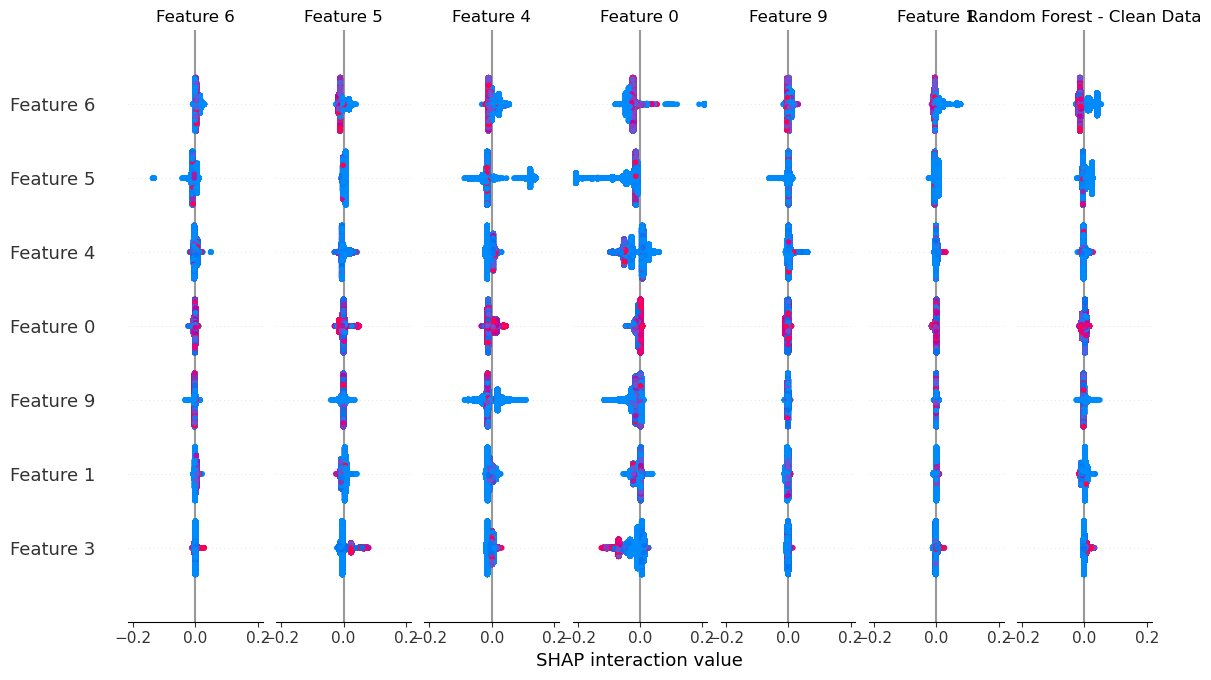

<Figure size 640x480 with 0 Axes>

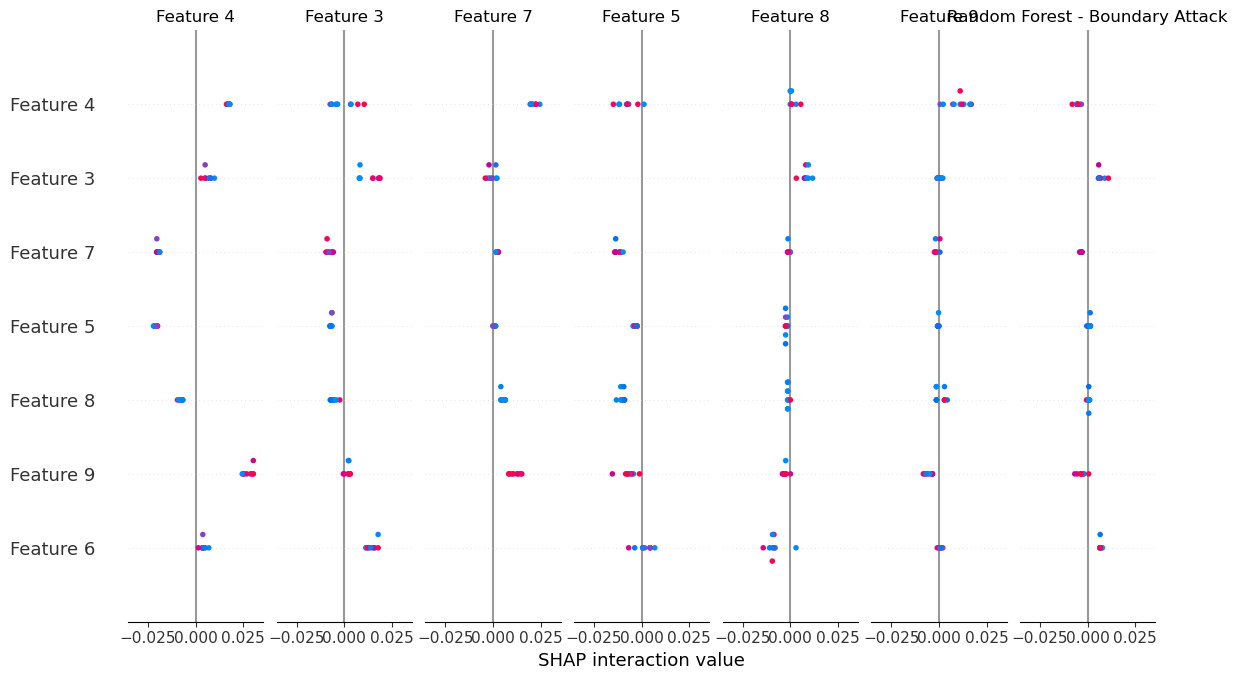

<Figure size 640x480 with 0 Axes>

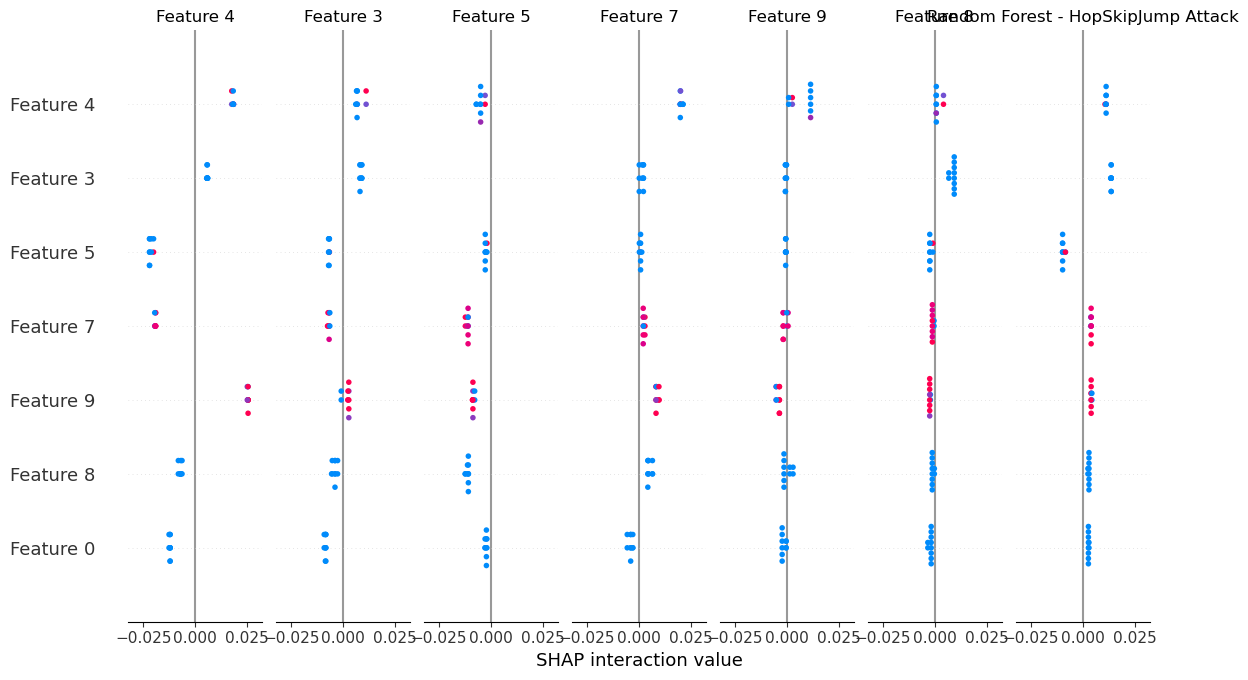

<Figure size 640x480 with 0 Axes>

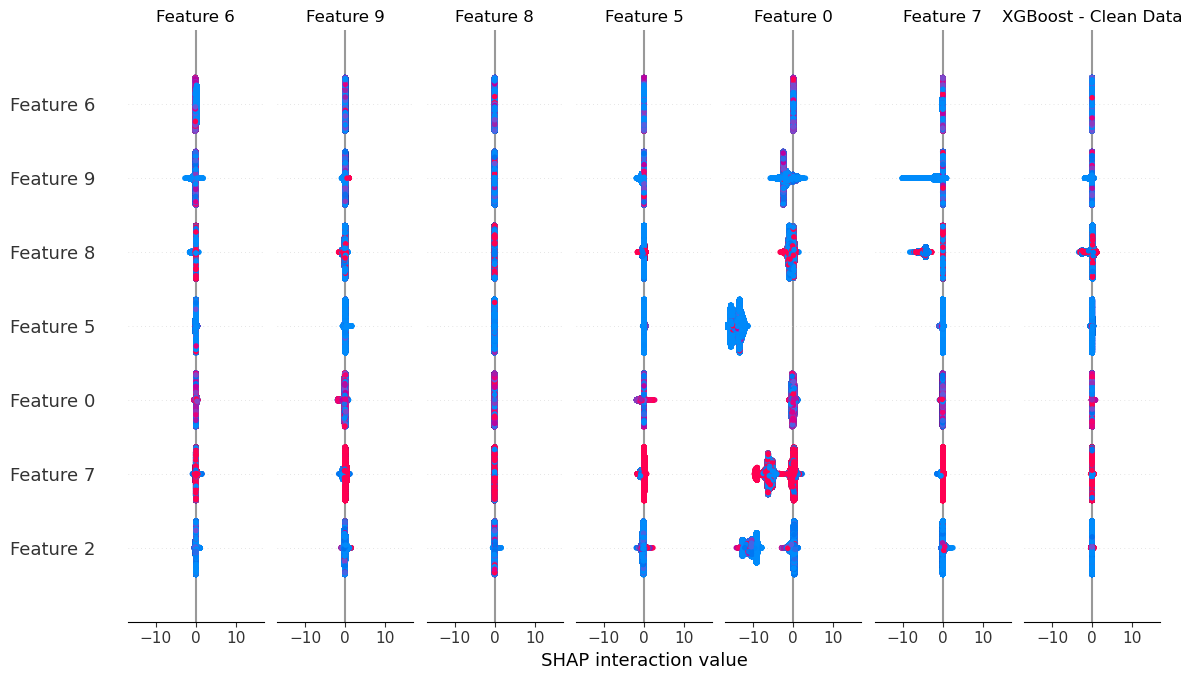

<Figure size 640x480 with 0 Axes>

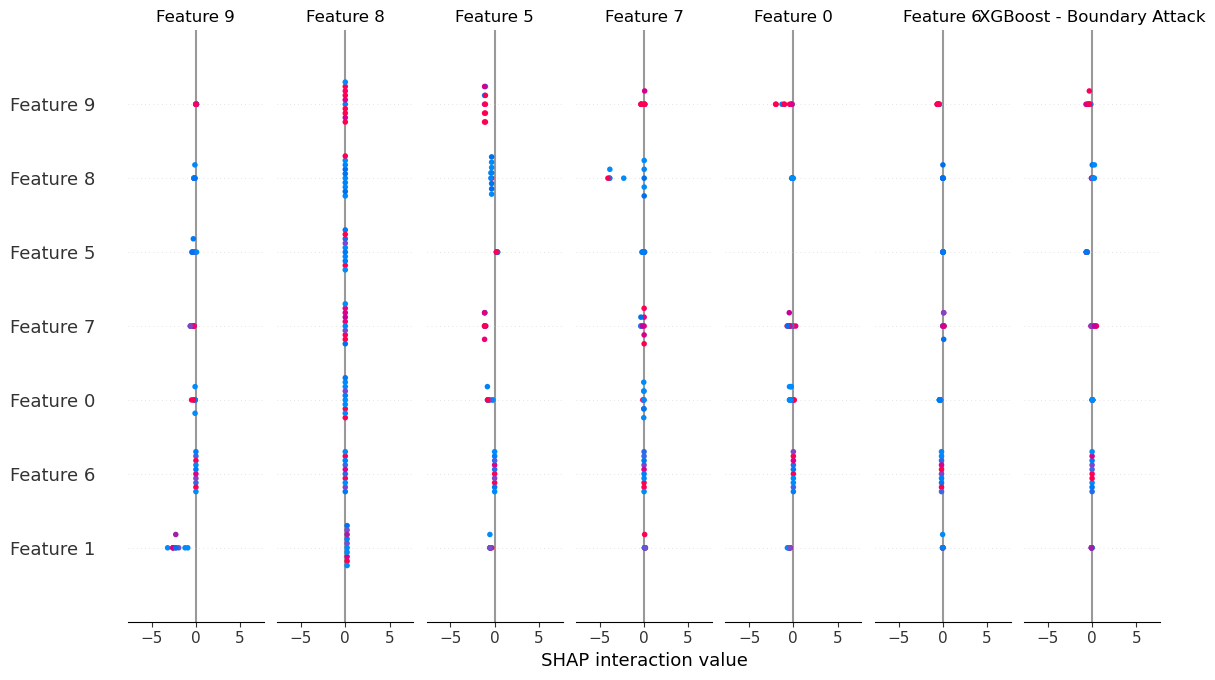

<Figure size 640x480 with 0 Axes>

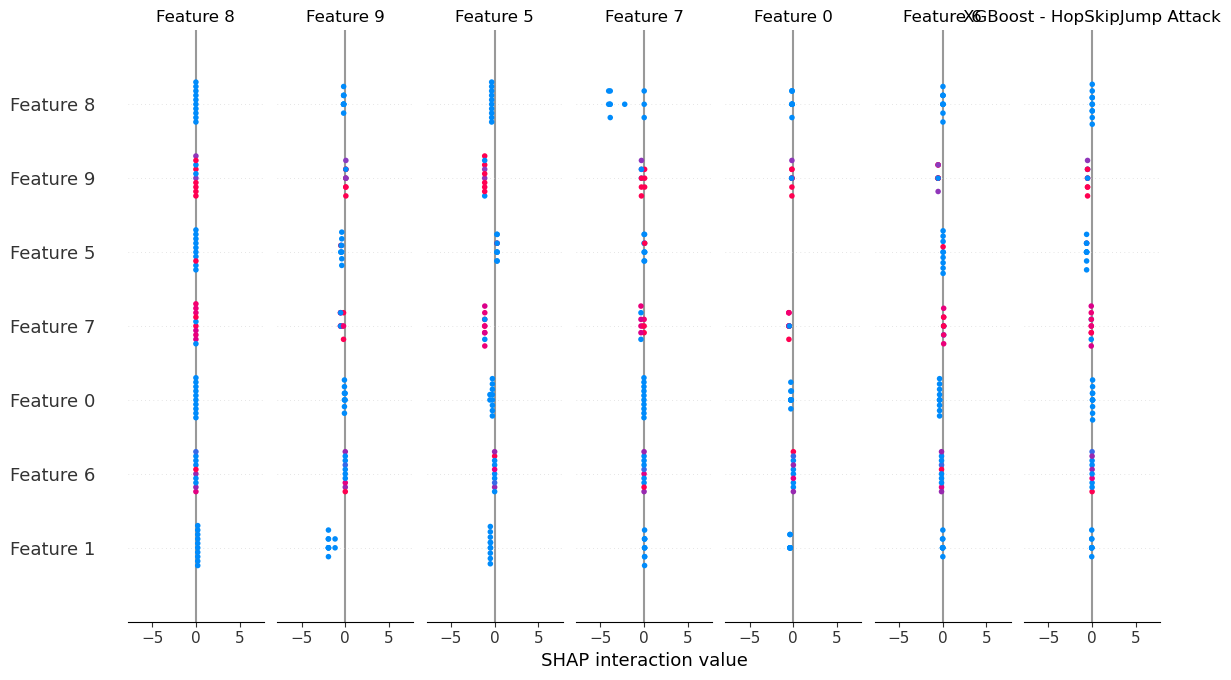

In [65]:
# Function to plot SHAP summary plots
def plot_shap_summary(shap_values, data, title):
    plt.figure()
    shap.summary_plot(shap_values, data, plot_type="bar", show=False)
    plt.title(title)
    plt.show()

# Random Forest
plot_shap_summary(shap_values_rf_clean, X_test_scaled, "Random Forest - Clean Data")
plot_shap_summary(shap_values_rf_boundary, X_adv, "Random Forest - Boundary Attack")
plot_shap_summary(shap_values_rf_hopskipjump, X_adv_hopskipjump, "Random Forest - HopSkipJump Attack")

# XGBoost
plot_shap_summary(shap_values_xgb_clean, X_test_scaled, "XGBoost - Clean Data")
plot_shap_summary(shap_values_xgb_boundary, X_adv, "XGBoost - Boundary Attack")
plot_shap_summary(shap_values_xgb_hopskipjump, X_adv_hopskipjump, "XGBoost - HopSkipJump Attack")


In [ ]:
plot_shap_summary(shap_values_svm_clean, X_test_scaled, "SVM - Clean Data")
plot_shap_summary(shap_values_svm_boundary, X_adv_boundary, "SVM - Boundary Attack")
plot_shap_summary(shap_values_svm_hopskipjump, X_adv_hopskipjump, "SVM - HopSkipJump Attack")